**Spectral Analysis of EEG Signals**

In [1]:
pip install numpy mne matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.4 MB/s eta 0:00:00


In [2]:
!pip install --upgrade mne

In [3]:
import os
import numpy as np
import scipy.io
import mne
from mne.time_frequency import psd_array_multitaper
import matplotlib.pyplot as plt

# Load and Preprocess Data

## Define file paths


In [4]:
set_path = '/content/preprocessed_data.set'
fdt_path = '/content/preprocessed_data.fdt'

## Load the .set file manually to inspect its content

In [5]:
eeg_data = scipy.io.loadmat(set_path, struct_as_record=False, squeeze_me=True)
print("EEGLAB .set file content:")
for key, value in eeg_data.items():
    if not key.startswith('__'):
        print(f"{key}: {type(value)}")

EEGLAB .set file content:
setname: <class 'str'>
filename: <class 'str'>
filepath: <class 'str'>
subject: <class 'numpy.ndarray'>
group: <class 'numpy.ndarray'>
condition: <class 'numpy.ndarray'>
session: <class 'numpy.ndarray'>
comments: <class 'numpy.ndarray'>
nbchan: <class 'int'>
trials: <class 'int'>
pnts: <class 'int'>
srate: <class 'int'>
xmin: <class 'float'>
xmax: <class 'float'>
times: <class 'numpy.ndarray'>
data: <class 'str'>
icaact: <class 'numpy.ndarray'>
icawinv: <class 'numpy.ndarray'>
icasphere: <class 'numpy.ndarray'>
icaweights: <class 'numpy.ndarray'>
icachansind: <class 'numpy.ndarray'>
chanlocs: <class 'numpy.ndarray'>
urchanlocs: <class 'numpy.ndarray'>
chaninfo: <class 'scipy.io.matlab._mio5_params.mat_struct'>
ref: <class 'str'>
event: <class 'numpy.ndarray'>
urevent: <class 'numpy.ndarray'>
eventdescription: <class 'numpy.ndarray'>
epoch: <class 'numpy.ndarray'>
epochdescription: <class 'numpy.ndarray'>
reject: <class 'scipy.io.matlab._mio5_params.mat_struct'

## Extract data shape information manually


In [6]:
nbchan = eeg_data['nbchan']
pnts = eeg_data['pnts']
trials = eeg_data['trials']
srate = eeg_data['srate']
print(f"Number of channels: {nbchan}")
print(f"Number of points per channel: {pnts}")
print(f"Number of trials: {trials}")
print(f"Sampling rate: {srate}")

Number of channels: 125
Number of points per channel: 1320
Number of trials: 1536
Sampling rate: 1200


## Load the .fdt file manually to inspect its content


In [7]:
dataset = np.fromfile(fdt_path, dtype=np.float32)
print(f"Data size: {dataset.size}")

Data size: 11796480


## Check if the total size matches


In [8]:
expected_size = nbchan * pnts * trials
if dataset.size < expected_size:
    print(f"Warning: Data size ({dataset.size}) is less than expected ({expected_size}), truncating the data.")
    expected_size = dataset.size

## Calculate new shape based on actual data size


In [9]:
trials_new = dataset.size // (nbchan * pnts)
print(f"Adjusted number of trials based on actual data: {trials_new}")

Adjusted number of trials based on actual data: 71


## Reshape the data manually


In [10]:
dataset = dataset[:nbchan * pnts * trials_new]
dataset = dataset.reshape((nbchan, pnts, trials_new), order='F')
print(f"Reshaped data shape: {dataset.shape}")

Reshaped data shape: (125, 1320, 71)


## Create MNE Info object

In [11]:
channel_names = [f'ch{i+1}' for i in range(nbchan)]
info = mne.create_info(ch_names=channel_names, sfreq=srate, ch_types='eeg')

## Convert to MNE Epochs object


In [12]:
epochs = mne.EpochsArray(dataset.transpose(2, 0, 1), info)

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


#Estimate PSD using Multitaper Method

## Apply the Multitaper method to estimate the PSD


In [13]:
psds, freqs = psd_array_multitaper(epochs.get_data(), sfreq=epochs.info['sfreq'], fmin=0.5, fmax=100, bandwidth=4.0, adaptive=True, low_bias=True, normalization='full', n_jobs=1)

    Using multitaper spectrum estimation with 3 DPSS windows


<ipython-input-13-a1bcecb71fd4>:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  psds, freqs = psd_array_multitaper(epochs.get_data(), sfreq=epochs.info['sfreq'], fmin=0.5, fmax=100, bandwidth=4.0, adaptive=True, low_bias=True, normalization='full', n_jobs=1)


## Convert power to dB


In [14]:
psds = 10 * np.log10(psds)

## Calculate mean and confidence intervals across epochs

In [15]:
psd_mean = np.mean(psds, axis=0)  # Shape (channels, frequencies)
psd_std = np.std(psds, axis=0)    # Same
conf_interval = 1.96 * psd_std / np.sqrt(psds.shape[0])  # Same

## Plot the PSD with confidence intervals


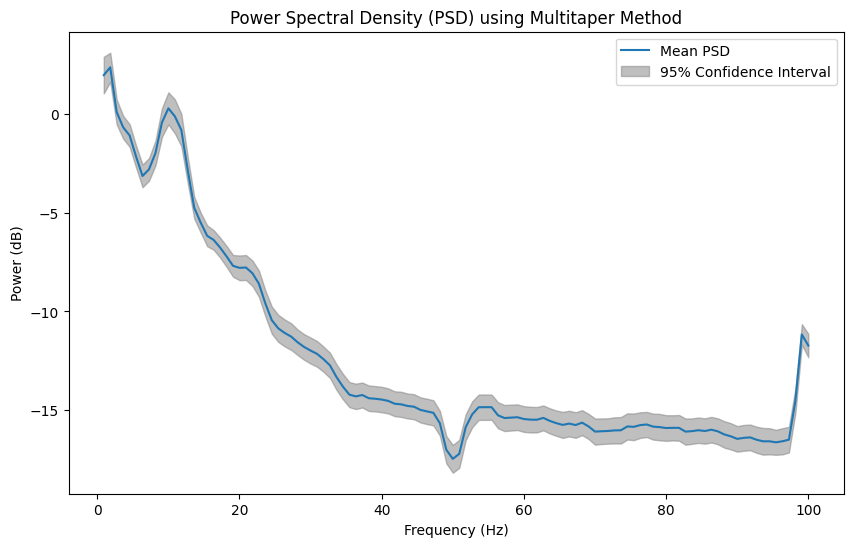

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
psd_mean_avg = np.mean(psd_mean, axis=0)
conf_interval_avg = np.mean(conf_interval, axis=0)

ax.plot(freqs, psd_mean_avg, label='Mean PSD')
ax.fill_between(freqs, psd_mean_avg - conf_interval_avg, psd_mean_avg + conf_interval_avg, color='gray', alpha=0.5, label='95% Confidence Interval')
ax.set_title('Power Spectral Density (PSD) using Multitaper Method')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')
ax.legend()
plt.show()

#Baseline Normalization and Comparison

## Adjust baseline period to be within the range of the epoch data


In [17]:
baseline_period = (0.0, 0.1)
epochs.apply_baseline(baseline=baseline_period)
psds_baseline, freqs = psd_array_multitaper(epochs.get_data(), sfreq=epochs.info['sfreq'], fmin=0.5, fmax=100, bandwidth=4.0, adaptive=True, low_bias=True, normalization='full', n_jobs=1)
psds_baseline = 10 * np.log10(psds_baseline)

Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 3 DPSS windows


<ipython-input-17-a597e9161308>:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  psds_baseline, freqs = psd_array_multitaper(epochs.get_data(), sfreq=epochs.info['sfreq'], fmin=0.5, fmax=100, bandwidth=4.0, adaptive=True, low_bias=True, normalization='full', n_jobs=1)


## Calculate mean and confidence intervals for baseline-normalized data


In [18]:
psd_mean_baseline = np.mean(psds_baseline, axis=0)
psd_std_baseline = np.std(psds_baseline, axis=0)
conf_interval_baseline = 1.96 * psd_std_baseline / np.sqrt(psds_baseline.shape[0])

## Plot PSD with and without baseline normalization

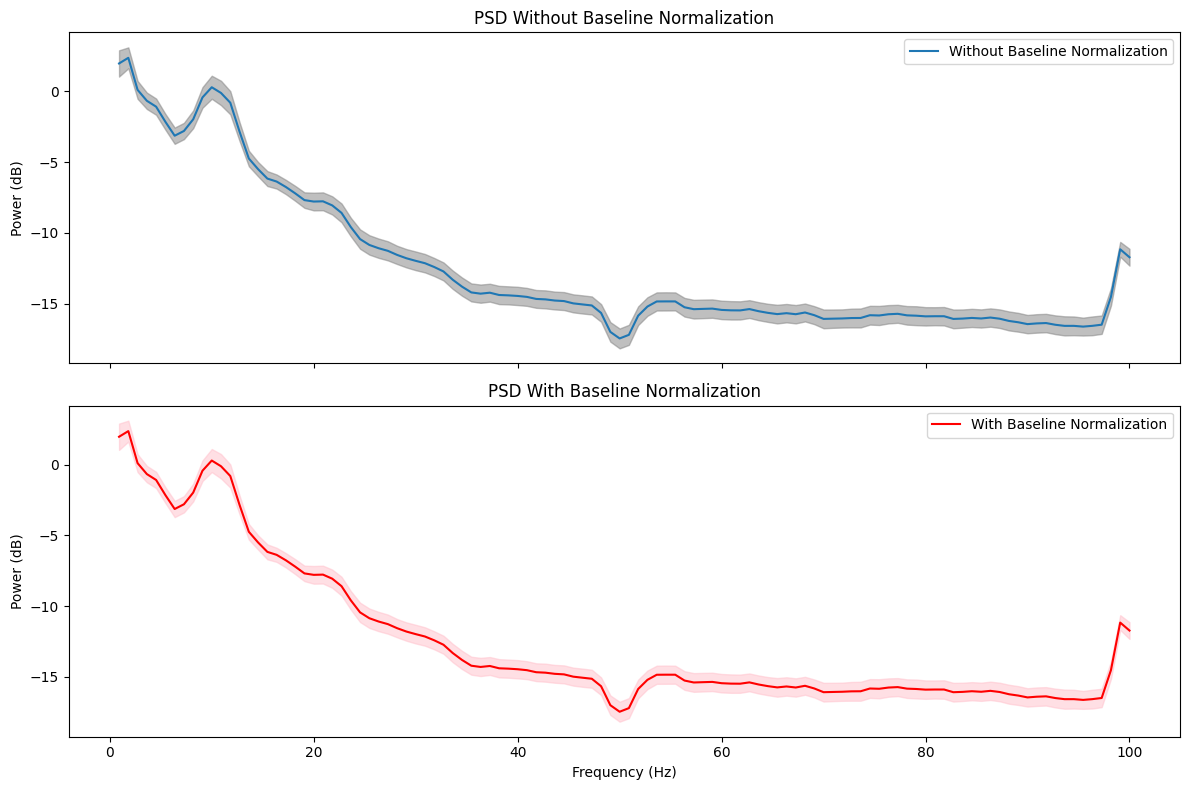

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Before
psd_mean_avg = np.mean(psd_mean, axis=0)
conf_interval_avg = np.mean(conf_interval, axis=0)
ax[0].plot(freqs, psd_mean_avg, label='Without Baseline Normalization')
ax[0].fill_between(freqs, psd_mean_avg - conf_interval_avg, psd_mean_avg + conf_interval_avg, color='gray', alpha=0.5)
ax[0].set_title('PSD Without Baseline Normalization')
ax[0].set_ylabel('Power (dB)')
ax[0].legend()

#After
psd_mean_baseline_avg = np.mean(psd_mean_baseline, axis=0)
conf_interval_baseline_avg = np.mean(conf_interval_baseline, axis=0)
ax[1].plot(freqs, psd_mean_baseline_avg, label='With Baseline Normalization', color='red')
ax[1].fill_between(freqs, psd_mean_baseline_avg - conf_interval_baseline_avg, psd_mean_baseline_avg + conf_interval_baseline_avg, color='pink', alpha=0.5)
ax[1].set_title('PSD With Baseline Normalization')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power (dB)')
ax[1].legend()

plt.tight_layout()
plt.show()

#Comparison of Results

In [20]:
# Define frequency bands
frequency_bands = {
    'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 100)
}

# Function to calculate average power in frequency bands
def calculate_power_band(psds, freqs, band):
    frequency_bands = np.logical_and(freqs >= band[0], freqs <= band[1])
    power_band = np.mean(psds[:, :, frequency_bands], axis=(0, 2))
    return power_band

## Calculate band powers for non-baseline-normalized PSD


In [21]:
power_bands = {}
for band_name, band_range in frequency_bands.items():
    power_bands[band_name] = calculate_power_band(psds, freqs, band_range)

print("Average power in frequency bands (non-baseline-normalized):")
for band_name, power in power_bands.items():
    print(f"{band_name}: {power} dB")

Average power in frequency bands (non-baseline-normalized):
Delta: [ 1.24049638  1.85972034  1.83124976 -0.51644083  1.00081561  3.79210022
  2.40116426  1.75451054 -0.77067005 -1.49440388  0.15561564  0.560229
  1.09524841  1.65306312  3.7900136   2.92062918  2.61972604  5.05830315
 -0.00822401 -2.17839516 -3.34805083 -1.30658512 -0.8697898   1.84326673
  4.91703837  1.73960548  0.76930334  1.37851609 -2.67013291 -2.61266135
 -2.98801957 -0.50548155 -0.49213823 -1.34390421 -0.90337051  1.78899161
  2.50728056  0.62755717 -1.82945564 -2.05696697 -0.48433934 -0.98102699
 -2.10441749 -0.57574538  4.04989716  2.41010081  1.87782557  1.40933305
  0.72273457  0.54361672 -1.20761136 -0.35114721 -0.12804962  4.33350003
  3.02417826  1.18907551  0.8945264   0.85594617  5.56897899  4.17146625
  1.41743554  0.20170615  1.34588997  3.14474095  3.07377668 -1.15937428
 -0.04525904  0.5683913   1.7434634   1.60655606  1.64095422  3.83538086
  2.47406518  0.10541683 -1.48130086 -2.55254377 -0.4864278

## Calculate band powers for baseline-normalized PSD


In [22]:
power_bands_baseline = {}
for band_name, band_range in frequency_bands.items():
    power_bands_baseline[band_name] = calculate_power_band(psds_baseline, freqs, band_range)

print("\nAverage power in frequency bands (baseline-normalized):")
for band_name, power in power_bands_baseline.items():
    print(f"{band_name}: {power} dB")


Average power in frequency bands (baseline-normalized):
Delta: [ 1.24049638  1.85972034  1.83124976 -0.51644083  1.00081561  3.79210022
  2.40116426  1.75451054 -0.77067005 -1.49440388  0.15561564  0.560229
  1.09524841  1.65306312  3.7900136   2.92062918  2.61972604  5.05830315
 -0.00822401 -2.17839516 -3.34805083 -1.30658512 -0.8697898   1.84326673
  4.91703837  1.73960548  0.76930334  1.37851609 -2.67013291 -2.61266135
 -2.98801957 -0.50548155 -0.49213823 -1.34390421 -0.90337051  1.78899161
  2.50728056  0.62755717 -1.82945564 -2.05696697 -0.48433934 -0.98102699
 -2.10441749 -0.57574538  4.04989716  2.41010081  1.87782557  1.40933305
  0.72273457  0.54361672 -1.20761136 -0.35114721 -0.12804962  4.33350003
  3.02417826  1.18907551  0.8945264   0.85594617  5.56897899  4.17146625
  1.41743554  0.20170615  1.34588997  3.14474095  3.07377668 -1.15937428
 -0.04525904  0.5683913   1.7434634   1.60655606  1.64095422  3.83538086
  2.47406518  0.10541683 -1.48130086 -2.55254377 -0.48642784 -

## Compare the two results


In [23]:
for band_name in frequency_bands.keys():
    diff = power_bands[band_name] - power_bands_baseline[band_name]
    print(f"\nDifference in {band_name} band power (non-baseline-normalized - baseline-normalized): {diff} dB")


Difference in Delta band power (non-baseline-normalized - baseline-normalized): [-4.44089210e-16 -4.44089210e-16  4.44089210e-16  0.00000000e+00
 -2.22044605e-16  0.00000000e+00  0.00000000e+00  2.22044605e-16
 -1.11022302e-16  0.00000000e+00  3.05311332e-16  0.00000000e+00
  4.44089210e-16  2.22044605e-16  8.88178420e-16  0.00000000e+00
 -4.44089210e-16  0.00000000e+00 -7.11236625e-17  4.44089210e-16
  0.00000000e+00  0.00000000e+00 -1.11022302e-16  4.44089210e-16
  0.00000000e+00  0.00000000e+00  1.11022302e-16  2.22044605e-16
  4.44089210e-16  0.00000000e+00  8.88178420e-16  1.11022302e-16
 -1.66533454e-16  0.00000000e+00  2.22044605e-16  4.44089210e-16
 -4.44089210e-16 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  1.66533454e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.22044605e-16
 -2.22044605e-16  0.00000000e+00  2.22044605e-16 -1.11022302e-16
 -2.49800181e-16  0.00000000e+00  0.00000000e+00  2.22044605e-16
 -3.33066